# Simulating whole-brain Drosophila spiking model with ``brainstate``

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chaobrain/brain-modeling-ecosystem/blob/main/docs/brainstate_drosophila_wholebrain_simulation.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/chaobrain/brain-modeling-ecosystem/blob/main/docs/brainstate_drosophila_wholebrain_simulation.ipynb)

Reproducing the simulation in the paper of:

- Shiu, P.K., Sterne, G.R., Spiller, N. et al. A Drosophila computational brain model reveals sensorimotor processing. Nature 634, 210–219 (2024). [https://doi.org/10.1038/s41586-024-07763-9](https://doi.org/10.1038/s41586-024-07763-9)

## Overview

This notebook builds a whole-brain spiking network for Drosophila using `brainstate`, driven by the FlyWire-derived connectome and stimulus protocols that mirror the paper.

What you will find here:
- Connectome ingestion (FlyWire 630 mirror) and neuron indexing.
- A leaky integrate-and-fire (LIF) population model with event-driven synapses, delays, and Poisson drive.
- Convenience helpers to run experiments, silence subsets, and aggregate activity.
- Code that reproduces/illustrates figure-style experiments (e.g., GRN/JON activation and MN/DN responses).

Prerequisites and runtime notes:
- JAX runs on CPU by default; a GPU accelerates long runs but is not required.
- The first build of sparse connectivity can take time proportional to the size of the edge list. Subsequent runs are faster due to caching.

Navigation:
- Start with the Connectome and Model sections, then use the Example Trial to sanity-check the setup.
- The later sections script specific figure-like experiments (sugar, water, bitter GRN; JON subtypes; MN9/DN readouts).


In [16]:
import itertools
import os
import pickle
from pathlib import Path
from typing import Callable, Union, Sequence, Dict, Optional

import brainevent
import brainstate
import braintools
import brainunit as u
import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Connectome dataset

This section fetches the FlyWire 630 connectome mirror via `kagglehub` and prepares the neuron index set used throughout.

Data files used by this notebook:
- `2023_03_23_completeness_630_final.csv`: canonical list of FlyWire neuron IDs (these define the row/column ordering of the network).
- `2023_03_23_connectivity_630_final.parquet`: long-format edge list with at least the columns `Presynaptic_Index`, `Postsynaptic_Index`, and `Excitatory x Connectivity`.

Implementation details:
- We construct a CSR sparse matrix from the edge list, sorted by presynaptic index for efficient iteration.
- Only the excitatory connectivity term is used to build the weight matrix; the scalar `w_syn` later rescales these values into mV.
- The returned `data_path` points to the locally cached dataset so repeated runs avoid re-downloading.



In [ ]:
import kagglehub

# Download latest version of Flywire 630 dataset from Kaggle
data_path = kagglehub.dataset_download("oujago/drosophila-630-data")

## Whole-brain Spiking Model

We model each neuron as a single-compartment LIF unit receiving event-based synaptic input and optional external Poisson drive. State variables:
- `v` membrane potential (mV), relaxing to `v_rest` with time constant `tau_m`.
- `g` a lumped synaptic drive (mV), relaxing with time constant `tau_syn` and incremented by inputs.
- `t_ref` tracks refractory timing; within `tau_ref`, updates are held constant.

Numerics and spikes:
- Dynamics are integrated with an exponential Euler step (`brainstate.nn.exp_euler_step`) for stability on reasonable `dt`.
- Spiking uses a smooth surrogate (`braintools.surrogate.ReluGrad`), which keeps code differentiable; we only simulate (no training) here.
- On a spike, `v` is reset to `v_reset`, `g` is cleared for that step, and `t_ref` is stamped.

Network wiring:
- Connectivity comes from a CSR matrix over the FlyWire index set and is applied via `brainstate.nn.SparseLinear`.
- A fixed synaptic delay (default 1.8 ms) is modeled using `brainstate.nn.Delay` and `brainevent` event arrays.
- External drive is applied to selected neurons by `brainstate.nn.poisson_input` with a per-event weight scaled by `w_syn * 250` to balance drive.
- Sets of neurons can be silenced through a boolean mask; silencing gates their outgoing spikes before they propagate.

Outputs and units:
- We record spike counts and convert to firing rates (Hz) by dividing by the simulated duration in seconds.
- All quantities carry physical units via `brainunit` (e.g., `ms`, `mV`, `Hz`) to help prevent unit mismatches.


In [17]:

class Population(brainpy.state.Neuron):
    """
    A population of neurons with leaky integrate-and-fire dynamics.

    The dynamics of the neurons are given by the following equations::

       dv/dt = (v_0 - v + g) / t_mbr : volt (unless refractory)
       dg/dt = -g / tau               : volt (unless refractory)


    Args:
      size: The number of neurons in the population.
      v_rest: The resting potential of the neurons.
      v_reset: The reset potential of the neurons after a spike.
      v_th: The threshold potential of the neurons for spiking.
      tau_m: The membrane time constant of the neurons.
      tau_syn: The synaptic time constant of the neurons.
      tau_ref: The refractory period of the neurons.
      spk_fun: The spike function of the neurons.
      name: The name of the population.

    """

    def __init__(
        self,
        size: brainstate.typing.Size,
        v_rest: u.Quantity = -52 * u.mV,  # resting potential
        v_reset: u.Quantity = -52 * u.mV,  # reset potential after spike
        v_th: u.Quantity = -45 * u.mV,  # potential threshold for spiking
        tau_m: u.Quantity = 20 * u.ms,  # membrane time constant
        # Jürgensen et al https://doi.org/10.1088/2634-4386/ac3ba6
        tau_syn: u.Quantity = 5 * u.ms,  # synaptic time constant
        # Lazar et al https://doi.org/10.7554/eLife.62362
        tau_ref: u.Quantity = 2.2 * u.ms,  # refractory period
        spk_fun: Callable = braintools.surrogate.ReluGrad(),  # spike function
        name: str = None,
    ):
        super().__init__(size, name=name)

        self.v_rest = v_rest
        self.v_reset = v_reset
        self.v_th = v_th
        self.tau_m = tau_m
        self.tau_syn = tau_syn
        self.tau_ref = u.math.full(self.varshape, tau_ref)
        self.spk_fun = spk_fun

    def init_state(self, batch_size=None):
        self.v = brainstate.ShortTermState(
            braintools.init.param(braintools.init.Constant(self.v_rest), self.varshape, batch_size))
        self.g = brainstate.ShortTermState(
            braintools.init.param(braintools.init.Constant(0.0 * u.mV), self.varshape, batch_size))
        self.t_ref = brainstate.ShortTermState(
            braintools.init.param(braintools.init.Constant(-1e7 * u.ms), self.varshape, batch_size))
        self.spike_count = brainstate.ShortTermState(
            braintools.init.param(braintools.init.Constant(0.), self.varshape, batch_size))

    def reset_state(self, batch_size=None):
        self.v.value = u.math.ones(self.varshape) * self.v_rest
        self.g.value = u.math.zeros(self.varshape) * u.mV
        self.t_ref.value = u.math.full(self.varshape, -1e7 * u.ms)

    def get_spike(self, v=None):
        v = self.v.value if v is None else v
        return self.spk_fun((v - self.v_th) / (20. * u.mV))

    def update(self, x):
        t = brainstate.environ.get('t')

        # numerical integration
        dv = lambda v, t, g: (self.v_rest - v + g) / self.tau_m
        dg = lambda g, t: -g / self.tau_syn
        v = brainstate.nn.exp_euler_step(dv, self.v.value, t, self.g.value)
        g = brainstate.nn.exp_euler_step(dg, self.g.value, t)
        g += x  # external input current
        v = self.sum_delta_inputs(v)

        # refractory period
        ref = (t - self.t_ref.value) <= self.tau_ref
        v = u.math.where(ref, self.v.value, v)
        g = u.math.where(ref, self.g.value, g)

        # spikes
        spk = self.get_spike(v)
        self.spike_count.value += spk

        # update states
        self.v.value = spk * (self.v_reset - v) + v
        self.g.value = g - spk * g
        self.t_ref.value = u.math.where(spk, t, self.t_ref.value)
        return spk


In [18]:
class Network(brainstate.nn.Module):
    def __init__(
        self,
        path_neu: Union[Path, str],
        path_syn: Union[Path, str],
        neuron_to_excite: Sequence[Dict] = (),
        neuron_to_inhibit: Sequence[Dict] = (),
        w_syn: u.Quantity = 0.275 * u.mV,
        neuron_params: Dict = None,
    ):
        super().__init__()

        self.path_neu = Path(path_neu)
        self.path_syn = Path(path_syn)

        # neuron ids
        flywire_ids = pd.read_csv(self.path_neu, index_col=0)
        self.n_neuron = len(flywire_ids)
        self._flyid2i = {f: i for i, f in enumerate(flywire_ids.index)}
        self._i2flyid = {i: f for i, f in enumerate(flywire_ids.index)}

        # neurons ids to excite
        self.neuron_to_excite = tuple([
            {
                'indices': (
                    u.math.asarray(exc['indices'])
                    if 'indices' in exc else
                    np.asarray([self._flyid2i[id_] for id_ in exc['ids']])
                ),  # neuron ids to excite
                'rate': exc['rate'],  # Poisson rate
                'w_syn': w_syn.clone() * 250,  # synaptic weight, 250 is the scaling factor for Poisson synapse
            }
            for exc in neuron_to_excite
        ])
        # neuron ids to inhibit
        neuron_to_inhibit = [
            (
                inh['indices']
                if 'indices' in inh else
                [self._flyid2i[i] for i in inh['ids']]
            )
            for inh in neuron_to_inhibit
        ]
        self.neuron_mask = jax.numpy.ones(self.n_neuron, dtype=bool)
        if len(neuron_to_inhibit) > 0:
            for indices in neuron_to_inhibit:
                self.neuron_mask = self.neuron_mask.at[indices].set(False)

        # neuronal and synaptic dynamics
        neuron_params = neuron_params or {}
        self.pop = Population(size=self.n_neuron, **neuron_params)

        # delay for changes in post-synaptic neuron
        # Paul et al 2015 doi: https://doi.org/10.3389/fncel.2015.00029
        self.delay = brainstate.nn.Delay(
            jax.ShapeDtypeStruct(self.pop.varshape, brainstate.environ.dftype()),
            entries={'D': 1.8 * u.ms}
        )

        # synapses: CSR connectivity matrix
        flywire_conns = pd.read_parquet(self.path_syn)
        i_pre = flywire_conns.loc[:, 'Presynaptic_Index'].values
        i_post = flywire_conns.loc[:, 'Postsynaptic_Index'].values
        weight = flywire_conns.loc[:, 'Excitatory x Connectivity'].values
        sort_indices = np.argsort(i_pre)
        i_pre = i_pre[sort_indices]
        i_post = i_post[sort_indices]
        weight = weight[sort_indices]

        values, counts = np.unique(i_pre, return_counts=True)
        indptr = np.zeros(self.n_neuron + 1, dtype=int)
        indptr[values + 1] = counts
        indptr = np.cumsum(indptr)
        indices = i_post

        self.conn = brainstate.nn.SparseLinear(
            brainevent.CSR(
                (weight * w_syn, indices, indptr),
                shape=(self.n_neuron, self.n_neuron)
            ),
            b_init=None,
        )

        # Poisson input
        for exc in self.neuron_to_excite:
            self.pop.tau_ref[exc['indices']] = 0. * u.ms  # set refractory period to 0.5 ms

    def update(self, *args, **kwargs):
        # excite neurons
        for exc in self.neuron_to_excite:
            brainstate.nn.poisson_input(
                freq=exc['rate'],
                num_input=1,
                weight=exc['w_syn'],
                target=self.pop.v,
                indices=exc['indices'],
            )

        # delayed spikes
        pre_spk = self.delay.at('D')

        # inhibit neurons
        if len(self.neuron_mask):
            pre_spk = pre_spk * self.neuron_mask

        # compute recurrent connections and update neurons
        spk = self.pop(self.conn(brainevent.EventArray(pre_spk)))

        # update delay spikes
        self.delay.update(spk)
        return spk

    def step_run(self, i, ret_val: str = 'none'):
        with brainstate.environ.context(t=i * brainstate.environ.get_dt(), i=i):
            spk = self.update()
            if ret_val == 'spike':
                return spk
            elif ret_val == 'voltage':
                return self.pop.v.value
            elif ret_val == 'conductance':
                return self.pop.g.value
            elif ret_val == 'spike_count':
                return self.pop.spike_count.value
            elif ret_val == 'none':
                return None
            else:
                raise ValueError('ret_val must be "spike", "voltage", "conductance", or "spike_count"')

## Utility Functions

This section provides helpers used across experiments:
- `run_one_exp(...)`: build the network with specified excitation/inhibition, run for a duration, and return per-neuron firing rates.
- `flywire_ids(path)`: load the canonical neuron ID ordering.
- `ndarray_to_dataframe(...)`: reshape multi-dimensional arrays into tidy Pandas DataFrames for plotting/analysis.

Later sections also define targeted wrappers (e.g., `which_*`, `*_activate_*`) that bundle stimulus configurations for the figure-style analyses.


In [19]:
def run_one_exp(
    neurons_to_excite: Sequence[dict],
    neuron_to_inhibit: Sequence = (),
    duration: brainstate.typing.ArrayLike = 1000 * u.ms,
    dt: brainstate.typing.ArrayLike = 0.1 * u.ms,
    pbar: int = 1000,
):
    with brainstate.environ.context(dt=dt):
        indices = np.arange(int(duration / brainstate.environ.get_dt()))

        assert isinstance(neurons_to_excite, (tuple, list)), 'neurons_to_excite must be a list or tuple'
        for exc in neurons_to_excite:
            assert isinstance(exc, dict), 'neurons_to_excite must be a list of dictionaries'
            assert 'ids' in exc or 'indices' in exc, 'neurons_to_excite must have a key "ids" or "indices"'
            assert 'rate' in exc, 'neurons_to_excite must have a key "rate"'
        assert isinstance(neuron_to_inhibit, (tuple, list)), 'neuron_to_inhibit must be a list or tuple'

        net = Network(
            path_neu=os.path.join(data_path, './2023_03_23_completeness_630_final.csv'),
            path_syn=os.path.join(data_path, './2023_03_23_connectivity_630_final.parquet'),
            neuron_to_excite=neurons_to_excite,
            neuron_to_inhibit=neuron_to_inhibit,
        )
        brainstate.nn.init_all_states(net)
        brainstate.transform.for_loop(
            net.step_run,
            indices,
            pbar=pbar
        )
        return net.pop.spike_count.value / duration.to_decimal(u.second)


In [20]:
def flywire_ids(neu_path: str | Path):
    df = pd.read_csv(neu_path, index_col=0)
    return np.asarray(df.index)

In [21]:
def ndarray_to_dataframe(
    arr,
    dim_names: Sequence,
    axis_names: Optional[Sequence[str]] = None,
    column_axis: Optional[int] = None,
    row_axis: Optional[int] = None
):
    """
    Convert a multidimensional NumPy array to a two-dimensional Pandas DataFrame.

    Parameters:
    - arr (numpy.ndarray): Input multi-dimensional array.
    - dim_names (list of list of str): List of names for each dimension.
    - column_axis (int): Specifies which dimension to use as DataFrame columns.
    - row_axis (int): Specifies which dimension to use as DataFrame rows, the remaining
        dimensions will be flattened into columns.

    Returns:
    - pd.DataFrame: Converted two-dimensional DataFrame.
    """

    # Validate input
    if not isinstance(arr, (np.ndarray, jax.Array)):
        raise TypeError("Input must be a NumPy array.")

    if not isinstance(dim_names, list) or len(dim_names) != arr.ndim:
        raise ValueError("dim_names must be a list with the same length "
                         "as the number of dimensions of the array.")
    for i, names in enumerate(dim_names):
        if len(names) != arr.shape[i]:
            raise ValueError(f"Length of dim_names[{i}] must be equal to "
                             f"the size of the corresponding dimension.")

    # Get indices for all dimensions
    axes = list(range(arr.ndim))

    if column_axis is None:
        assert row_axis is not None, 'row_axis must be specified if column_axis is None'

        if not isinstance(row_axis, int):
            if row_axis < 0:
                row_axis = row_axis + arr.ndim
            if not (0 <= row_axis < arr.ndim):
                raise ValueError("row_axis must be a valid dimension index.")

        # Separate row dimension and column dimensions
        row_dim = row_axis
        column_dims = axes[:row_dim] + axes[row_dim + 1:]

        # Get row labels
        row_labels = dim_names[row_dim]

        # Get labels for each column dimension
        column_dim_names = [dim_names[dim] for dim in column_dims]

        # Generate all combinations of column labels
        if column_dim_names:
            column_tuples = list(itertools.product(*column_dim_names))
            # Convert tuples to string labels, e.g., ('Feature_X', 'Measurement_I') -> 'Feature_X_Measurement_I'
            column_labels = ['_'.join(col) for col in column_tuples]
        else:
            # If there is only one dimension as rows, there are no columns
            column_labels = []

        # Rearrange array axes to move row axis to the first position,
        # keeping the order of the remaining dimensions
        reordered_axes = [row_dim] + column_dims
        arr_reordered = np.transpose(arr, axes=reordered_axes)

        # Get new shape
        new_shape = arr_reordered.shape
        num_rows = new_shape[0]
        num_cols = np.prod(new_shape[1:]).astype(int) if len(new_shape) > 1 else 1

        # Flatten all dimensions except the row dimension into columns
        arr_flat = arr_reordered.reshape(num_rows, num_cols)

        # If there are multiple column dimensions, generate combined
        # column labels; otherwise, use a single column label
        if len(column_dims) > 0:
            if len(column_dims) == 1:
                # Only one column dimension, directly use its labels
                column_labels = dim_names[column_dims[0]]
            else:
                # Multiple column dimensions, combine labels
                column_labels = [
                    '_'.join([dim_names[dim][i] for dim, i in zip(column_dims, idx)])
                    for idx in itertools.product(*[range(len(dim_names[dim])) for dim in column_dims])
                ]

        # Create row index
        index = pd.Index(row_labels, name=dim_names[row_dim][0] if len(dim_names[row_dim]) > 0 else f"dim_{row_dim}")

        # Create column index
        if column_labels:
            columns = column_labels
        else:
            # If there are no column labels, create a default single column
            columns = ['Value']
            arr_flat = arr_flat.flatten()

    else:
        assert row_axis is None, 'row_axis must be None if column_axis is specified'

        if not isinstance(column_axis, int):
            if column_axis < 0:
                column_axis = column_axis + arr.ndim
            if not (0 <= column_axis < arr.ndim):
                raise ValueError("column_axis must be a valid dimension index.")

        # Separate column dimension and row dimensions
        column_dim = column_axis
        row_dims = axes[:column_dim] + axes[column_dim + 1:]

        # Get column labels
        columns = dim_names[column_dim]

        # Get labels for each row dimension
        row_dim_names = [dim_names[dim] for dim in row_dims]

        # Generate all combinations of row labels
        row_tuples = list(itertools.product(*row_dim_names))

        # Rearrange array axes to move column axis to the last position
        reordered_axes = row_dims + [column_dim]
        arr_reordered = arr.transpose(reordered_axes)

        # Calculate number of rows and columns
        num_rows = arr_reordered.shape[:-1]
        num_cols = arr_reordered.shape[-1]

        # Flatten all dimensions except the column dimension
        arr_flat = arr_reordered.reshape(-1, num_cols)

        # Create row index, use MultiIndex if there are multiple row dimensions
        if len(row_dims) > 1:
            if axis_names is None:
                names = [f"dim_{dim}" for dim in row_dims]
            else:
                assert len(axis_names) == arr.ndim, 'axis_names must have the same length as the number of dimensions'
                names = [axis_names[dim] for dim in range(arr.ndim)]
            index = pd.MultiIndex.from_tuples(row_tuples, names=names)
        else:
            index = pd.Index(row_tuples, )

    # Create DataFrame
    df = pd.DataFrame(arr_flat, index=index, columns=columns)
    return df


## Model settings

Global parameters used by the examples that follow:
- `n_trial`: how many repeated runs to average over for robustness.
- `duration`: simulation length per run (with `dt` typically set in context, e.g., 0.1 ms).
- `all_neuron_ids` and `flywire_id_to_index`: mappings between FlyWire IDs and zero-based indices into the state vectors.


In [23]:
n_trial = 5
duration = 100. * u.ms

all_neuron_ids = flywire_ids(os.path.join(data_path, './2023_03_23_completeness_630_final.csv'))
flywire_id_to_index = {f: i for i, f in enumerate(all_neuron_ids)}

## Example Trial

A minimal end-to-end run that drives a subset of sugar-sensing GRNs (right hemisphere) with a Poisson process and visualizes the resulting spikes across the whole network.

How to adapt:
- Replace `neu_sugar` with another neuron list (e.g., water or bitter GRNs, JON subtypes, or arbitrary IDs).
- Tweak the input `rate` (in Hz), the `duration`, or neuron parameters (e.g., `tau_m`, `tau_syn`, `w_syn`) to explore sensitivity.
- Use `ret_val='spike'|'voltage'|'conductance'` in `step_run` to capture different observables.


In [24]:
# define inputs
# list of the labellar sugar-sensing gustatory receptor neurons on right hemisphere
neu_sugar = [
    720575940624963786, 720575940630233916, 720575940637568838, 720575940638202345, 720575940617000768,
    720575940630797113, 720575940632889389, 720575940621754367, 720575940621502051, 720575940640649691,
    720575940639332736, 720575940616885538, 720575940639198653, 720575940620900446, 720575940617937543,
    720575940632425919, 720575940633143833, 720575940612670570, 720575940628853239, 720575940629176663,
    720575940611875570,
]

In [25]:
def example_to_run(duration=1000 * u.ms):
    with brainstate.environ.context(dt=0.1 * u.ms):
        net = Network(
            path_neu=os.path.join(data_path, './2023_03_23_completeness_630_final.csv'),
            path_syn=os.path.join(data_path, './2023_03_23_connectivity_630_final.parquet'),
            neuron_to_excite=[
                # sugar neuron
                {
                    'ids': neu_sugar,
                    'rate': 150 * u.Hz
                },
                # other neuron groups
            ],
        )
        brainstate.nn.init_all_states(net)

        indices = np.arange(int(duration / brainstate.environ.get_dt()))
        times = indices * brainstate.environ.get_dt()
        spks = brainstate.transform.for_loop(lambda i: net.step_run(i, ret_val='spike'), indices, pbar=1000)

    fig, gs = braintools.visualize.get_figure(1, 1, 5, 5)
    ax = fig.add_subplot(gs[0, 0])
    i_times, i_indices = np.where(spks)
    plt.scatter(times[i_times], i_indices, s=1)
    plt.xlabel('Time [ms]')
    plt.ylabel('Neuron index')
    plt.ylim(0, net.n_neuron)
    plt.xlim(0 * u.ms, duration)
    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

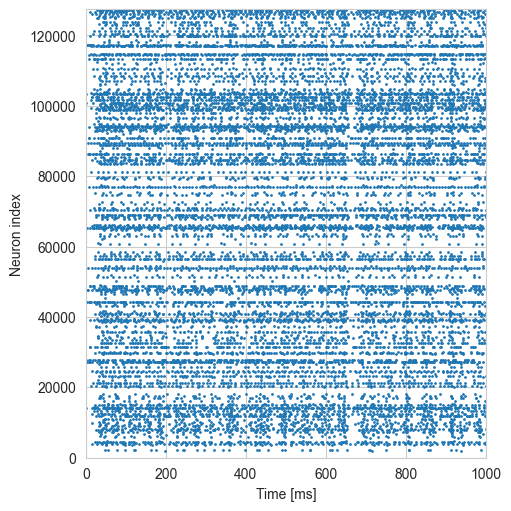

In [26]:
example_to_run()

## Figure 1

The following cells script experiments that mirror Figure 1 panels in the paper. For each panel we:
- Define the stimulated neuron set(s) and their Poisson drive rates.
- Optionally silence subsets (to assess causal contribution).
- Run the simulation and aggregate whole-brain activity or specific readouts (e.g., MN9).

Note: Exact numerical replication may differ due to model simplifications (single-compartment LIF, weight rescaling) and environment details (JAX device, random seeds). The qualitative patterns and causal trends should match.


In [27]:
fig1_path_res = Path('./figure_1')
os.makedirs(fig1_path_res, exist_ok=True)

### Figure 1 D: Whole Brain Activity when Activating Sugar GRN

In [28]:
# frequencies
freqs = np.arange(10, 201, 20)

In [29]:
def whole_brain_activation():
    @brainstate.transform.vmap
    def run_with_freq(freq_):
        return run_one_exp(
            neurons_to_excite=[{'ids': neu_sugar, 'rate': freq_ * u.Hz}],
            duration=duration, pbar=10,
        )

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def run_simulations():
        return run_with_freq(freqs)

    if not os.path.exists(fig1_path_res / 'firing_rate.csv'):
        rates = run_simulations()

        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'{freq} Hz' for freq in freqs],
                all_neuron_ids
            ],
            column_axis=0
        )
        df.to_csv(fig1_path_res / 'firing_rate.csv')

        df_rate = df.loc['190 Hz'].mean(axis=1)
        df_rate_std = df.loc['190 Hz'].std(axis=1)

        # save 200 neurons for next simulation
        id_top200 = df_rate.sort_values(ascending=False).index[:200]

        print(df_rate.sort_values(ascending=False))

        with open(fig1_path_res / 'fig_1d_id_top200.pickle', 'wb') as f:
            pickle.dump(id_top200, f)

In [ ]:
whole_brain_activation()

  0%|          | 0/1000 [00:00<?, ?it/s]

### Figure 1 E:  Which neurons activate MN9?

In [22]:
# define inputs
# flywire ID for MN9
id_mn9 = 720575940660219265

index_id_mn9 = flywire_id_to_index[id_mn9]

# identify the top 200 neurons that respond due to 200 Hz sugar firing (Figure 1D)
with open(fig1_path_res / 'fig_1d_id_top200.pickle', 'rb') as f:
    id_top200 = pickle.load(f)

In [23]:
# neuron indices
indices = np.asarray([flywire_id_to_index[id_] for id_ in id_top200])
indices = np.expand_dims(indices, axis=1)

In [24]:
def which_neuron_activate_MN9(freqs):
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_freq(freq_, indices_):
        assert indices_.ndim == 1 and indices_.size == 1
        rate = run_one_exp(
            neurons_to_excite=[{'indices': indices_, 'rate': freq_ * u.Hz}],
            duration=duration,
            pbar=10
        )
        return rate[index_id_mn9]

    def run_with_indices(indices_):
        return run_with_freq(freqs, indices_)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        # due to the limited memory of the device, we choose using "brainstate.transform.map" instead of "brainstate.transform.vmap"

        # return bst.transform.vmap(run_with_indices)(bst.random.split_key(len(indices)), indices)
        return brainstate.transform.map(run_with_indices, indices, batch_size=20)

    path = fig1_path_res / f'which_neuron_activate_NM9_firing_rate.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                id_top200,
                [f'{freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [25]:
which_neuron_activate_MN9(
    np.asarray([25, 50, 75, 100, 125, 150, 175, 200])
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

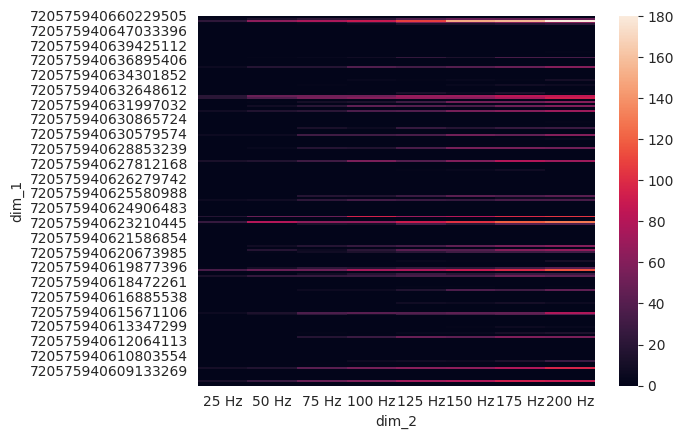

In [26]:
df = pd.read_csv(fig1_path_res / f'which_neuron_activate_NM9_firing_rate.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df.sort_index(ascending=False, inplace=True)
pivot_df = pivot_df.fillna(0)
pivot_df = pivot_df.reindex([f'{f} Hz' for f in [25, 50, 75, 100, 125, 150, 175, 200]], axis=1)

sns.heatmap(pivot_df)
plt.show()

### Figure 1F: Silencing

In [30]:
# neuron indices
silencing_indices = np.asarray([flywire_id_to_index[id_] for id_ in id_top200])
silencing_indices = np.expand_dims(silencing_indices, axis=1)

In [31]:
def slice_neuron_and_activate_MN9(freqs):
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_freq(freq_, indices_):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_sugar, 'rate': freq_ * u.Hz}],
            neuron_to_inhibit=[{'indices': indices_}],
            duration=duration,
            pbar=10
        )
        return rate[index_id_mn9]

    def run_with_indices(indices_):
        return run_with_freq(freqs, indices_)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        # Due to the limited memory of the device, we choose using "brainstate.transform.map" instead of "brainstate.transform.vmap"
        # Decrease "batch_size" when out of memory

        # return bst.transform.vmap(run_with_indices)(bst.random.split_key(len(silencing_indices)), silencing_indices)
        return brainstate.transform.map(run_with_indices, silencing_indices, batch_size=20)

    path = fig1_path_res / f'sugarR-silencing_which_neuron_firing_rate.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                id_top200,
                [f'{freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [32]:
slice_neuron_and_activate_MN9(
    np.asarray([50, 60, 70, 80, 90, 100, 110, 120])
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

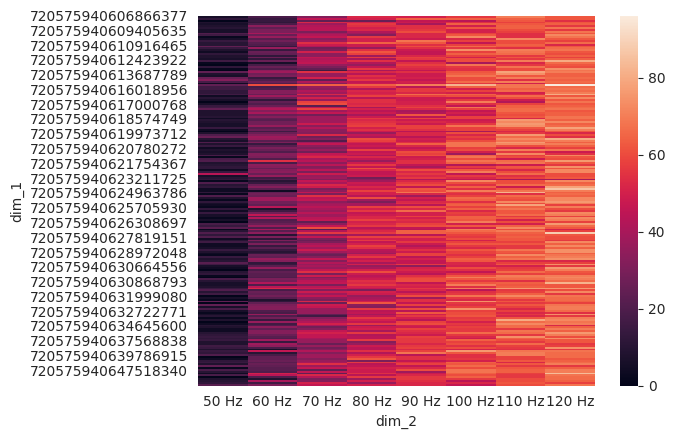

In [33]:
df = pd.read_csv(fig1_path_res / f'sugarR-silencing_which_neuron_firing_rate.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)
pivot_df = pivot_df.reindex([f'{f} Hz' for f in [50, 60, 70, 80, 90, 100, 110, 120]], axis=1)

sns.heatmap(pivot_df)
plt.show()

## Figure 2: Which Cell Type Activates MN9?

In [34]:
# output path
fig2_path_res = Path('./figure_2')
os.makedirs(fig2_path_res, exist_ok=True)

In [35]:
# define input
ids_two_mn9 = [720575940660219265, 720575940645521262]  # left and right

index_id_mn9 = np.asarray(
    [flywire_id_to_index[ids_two_mn9[0]],
     flywire_id_to_index[ids_two_mn9[1]]]
)

with open('./sez_neurons.pickle', 'rb') as f:
    types_and_ids = pickle.load(f)

In [36]:
def which_cell_type_activates_MN9(cell_ids, type_name, freqs):
    @brainstate.transform.vmap
    def run_with_freq(freq_):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': cell_ids, 'rate': freq_ * u.Hz}],
            duration=duration,
            pbar=10
        )
        return rate[index_id_mn9]

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        return run_with_freq(freqs)

    path = fig2_path_res / f'cell_type={type_name}.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'{freq} Hz' for freq in freqs],
                ids_two_mn9
            ],
            column_axis=0
        )
        df.to_csv(path)

In [37]:
for cell_type_name, neurons in types_and_ids.items():
    print('Activating MN9 with cell type', cell_type_name)
    which_cell_type_activates_MN9(
        neurons,
        cell_type_name,
        np.asarray([50, 100, 150, 200])
    )

Activating MN9 with cell type aDT6


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type amulet


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type aSG1


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type aSG7


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type aster


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type Asteroid


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type bamboo


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type basket


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type bluebell


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type bobber


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type box


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type bract


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type bridle


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type brontosaraus


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type broom


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type buddy


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type clavicle


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type coy


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type crab


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type cradle


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type damsel


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type diatom


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type doublescoop


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type earmuff


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type eiffel


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type Fdg


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type fluff


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type FMIn


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type foxglove


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type fudog


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type G2N_1


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type gallinule


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type gazebo


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type genie


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type gnome


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type good_dog


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type gumdrop


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type handle


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type handup


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type haystack


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type horntail


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type horseshoe


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type horn


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type hound


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type hyacinth


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type justice


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type kelp


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type kitty


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type knees


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type kokopelli


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type landslide


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type lion


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type mandala


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type marge


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type meteor


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type mime


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type mist


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type moor


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type mothership


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type mute


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type nagini


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type nori


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type oink


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type OinkT


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type oval


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type peacock


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type peahen


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type peafowl


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type phantom


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type planter


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type pleco


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type pringle


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type pSG1


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type puddle


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type rattle


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type rocket


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type rose


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type roundup


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type ruby


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type Salivary_MN13


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type seagull


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type shark


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type sink_sync


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type snake


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type spray


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type spirit


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type sullivan


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type sundrop


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type tentacular


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type TH_VUM


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type tinctoria


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type tophat


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type TPN4


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type trident


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type trogon


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type trumpet


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type tulip


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type tundra


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type turner


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type twirl


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type usnea


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type vice


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type wafflecone


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type weaver


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type web


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type whisker


  0%|          | 0/1000 [00:00<?, ?it/s]

In [1]:
# dfs = [
#     pd.read_csv(fig2_path_res / f'cell_type={cell_type_name}.csv').mean(axis=1)
#     for cell_type_name in types_and_ids.keys()
# ]
#
# # process results
# for freq in freqs:
#     plt.figure(figsize=(12, 6))
#     x_labels = list(types_and_ids.keys())
#     y_values = [df.loc[ids_two_mn9].mean() for df in dfs]
#
#     plt.bar(x_labels, y_values, color='skyblue')
#     plt.xlabel('Cell Type')
#     plt.ylabel('Firing of MN9')
#     plt.title(f'Relationship Between Cell Type and MN9 Firing (Frequency = {freq} Hz)')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.show()

## Figure 3

In [39]:
fig3_path_res = Path('./figure_3')
os.makedirs(fig3_path_res, exist_ok=True)

### Figure 3 A: Combination of Bitter and Sugar GRN

In [40]:
# define inputs
# lists of all the labelled sugar-sensing gustatory receptor neurons on right hemisphere
neu_bitter = [
    720575940621778381, 720575940602353632, 720575940617094208, 720575940619197093, 720575940626287336,
    720575940618600651, 720575940627692048, 720575940630195909, 720575940646212996, 720575940610483162,
    720575940645743412, 720575940627578156, 720575940622298631, 720575940621008895, 720575940629146711,
    720575940610259370, 720575940610481370, 720575940619028208, 720575940614281266, 720575940613061118,
    720575940604027168
]

neu_ir94e = [
    720575940614211295, 720575940638218173, 720575940628832256, 720575940626016017, 720575940621375231,
    720575940612920386, 720575940614273292, 720575940628198503, 720575940626241636, 720575940619387814,
    720575940624604560, 720575940615274425, 720575940610683315, 720575940627265265, 720575940624079544,
    720575940629211607, 720575940615089369, 720575940631082124
]

id_mn9 = 720575940660219265  # left
index_mn9 = flywire_id_to_index[id_mn9]

In [41]:
def sugar_bitter_activate_MN9(freqs):
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_sugar_freq(sugar_freq, bitter_freq):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_sugar, 'rate': sugar_freq * u.Hz},
                               {'ids': neu_bitter, 'rate': bitter_freq * u.Hz}],
            duration=duration,
            pbar=10,
        )
        return rate[index_mn9]

    @brainstate.transform.vmap
    def run_with_bitter_freq(bitter_freq):
        return run_with_sugar_freq(freqs, bitter_freq)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        return run_with_bitter_freq(freqs)

    path = fig3_path_res / f'sugar_bitter_activate_MN9.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'bitter {freq} Hz' for freq in freqs],
                [f'sugar {freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [42]:
sugar_bitter_activate_MN9(
    np.asarray([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
)

  0%|          | 0/1000 [00:00<?, ?it/s]

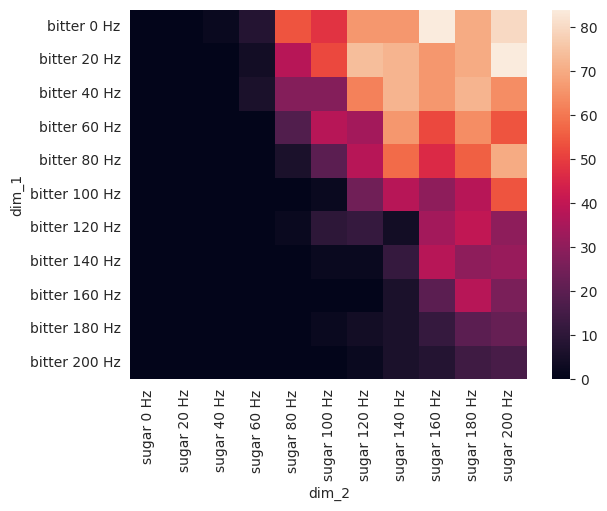

In [43]:
df = pd.read_csv(fig3_path_res / f'sugar_bitter_activate_MN9.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)
pivot_df = pivot_df.reindex([f'sugar {f} Hz' for f in [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]], axis=1)
pivot_df = pivot_df.reindex([f'bitter {f} Hz' for f in [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]], axis=0)

sns.heatmap(pivot_df)
plt.show()

### Figure 3 B: Combination of Sugar and IR94e GRN

In [44]:
def sugar_ir94e_activates_MN9(freqs):
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_sugar_freq(sugar_freq, ir94e_freq):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_sugar, 'rate': sugar_freq * u.Hz},
                               {'ids': neu_ir94e, 'rate': ir94e_freq * u.Hz}],
            duration=duration,
            pbar=10,
        )
        return rate[index_mn9]

    @brainstate.transform.vmap
    def run_with_ir94e_freq(ir94e_freq):
        return run_with_sugar_freq(freqs, ir94e_freq)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        return run_with_ir94e_freq(freqs)

    path = fig3_path_res / f'sugar_ir94e_activates_MN9.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'ir94e {freq} Hz' for freq in freqs],
                [f'sugar {freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [45]:
sugar_ir94e_activates_MN9(
    np.asarray([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
)

  0%|          | 0/1000 [00:00<?, ?it/s]

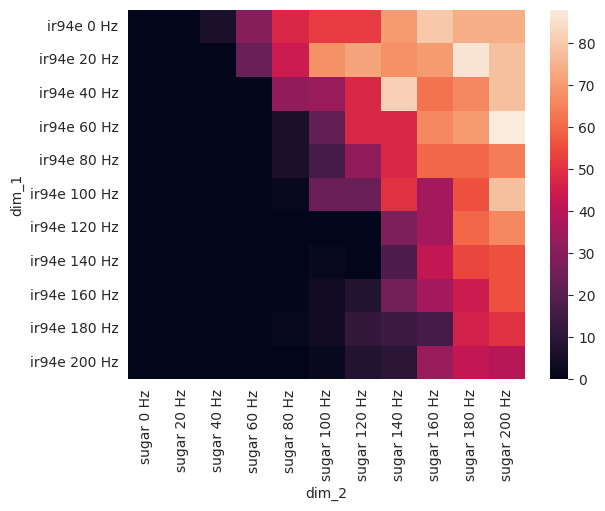

In [46]:
df = pd.read_csv(fig3_path_res / f'sugar_ir94e_activates_MN9.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)
pivot_df = pivot_df.reindex([f'sugar {f} Hz' for f in [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]], axis=1)
pivot_df = pivot_df.reindex([f'ir94e {f} Hz' for f in [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]], axis=0)

sns.heatmap(pivot_df)
plt.show()

## Figure 4

In [47]:
fig4_path_res = Path('./figure_4')
os.makedirs(fig4_path_res, exist_ok=True)

### Figure 4a: Whole Brain Activity when Activating Water GRN

In [48]:
# define inputs
# list of the labelled water-sensing gustatory receptor neurons on right hemisphere
neu_water = [
    720575940612950568, 720575940631898285, 720575940606002609, 720575940612579053, 720575940622902535,
    720575940616177458, 720575940660292225, 720575940622486922, 720575940613786774, 720575940629852866,
    720575940625861168, 720575940613996959, 720575940617857694, 720575940644965399, 720575940625203504,
    720575940630553415, 720575940635172191, 720575940634796536
]

In [49]:
def water_GRN_whole_brain_activation(freqs):
    @brainstate.transform.vmap
    def run_with_freq(freq_):
        return run_one_exp(
            neurons_to_excite=[
                {
                    'ids': neu_water,
                    'rate': freq_ * u.Hz
                }
            ],
            duration=duration,
            pbar=10,
        )

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def run_simulations():
        return run_with_freq(freqs)

    path = fig4_path_res / 'water_GRN_whole_brain_firing_rate.csv'
    if not os.path.exists(path):
        rates = run_simulations()

        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'{freq} Hz' for freq in freqs],
                all_neuron_ids
            ],
            column_axis=0
        )
        df.to_csv(path)

        df_rate = df.loc['260 Hz'].mean(axis=1)
        df_rate_std = df.loc['260 Hz'].std(axis=1)

        # save 200 neurons for next simulation
        id_top200 = df_rate.sort_values(ascending=False).index[:200]

        print(df_rate.sort_values(ascending=False))

        with open(fig4_path_res / 'id_top200_water.pickle', 'wb') as f:
            pickle.dump(id_top200, f)

In [50]:
water_GRN_whole_brain_activation(
    np.asarray([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260])
)

  0%|          | 0/1000 [00:00<?, ?it/s]

dim_2
720575940606002609    288.0
720575940612950568    284.0
720575940631898285    282.0
720575940613996959    276.0
720575940622486922    270.0
                      ...  
720575940620591494      0.0
720575940620591454      0.0
720575940620591425      0.0
720575940620591380      0.0
720575940660868737      0.0
Length: 127400, dtype: float32


### Figure 4b: Which Water GRN activates MN9?

In [51]:
# define inputs
# flywire ID for MN9
id_mn9 = 720575940660219265

index_id_mn9 = flywire_id_to_index[id_mn9]

# identify the top 200 neurons that respond due to 200 Hz water firing (Figure 1D)
with open(fig4_path_res / 'id_top200_water.pickle', 'rb') as f:
    id_top200_water = pickle.load(f)

# neuron indices
water_top200_indices = np.asarray([flywire_id_to_index[id_] for id_ in id_top200_water])
water_top200_indices = np.expand_dims(water_top200_indices, axis=1)

In [55]:
def which_water_neuron_activate_MN9(freqs):
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_freq(freq_, indices_):
        assert indices_.ndim == 1 and indices_.size == 1
        rate = run_one_exp(
            neurons_to_excite=[{'indices': indices_, 'rate': freq_ * u.Hz}],
            duration=duration,
            pbar=10
        )
        return rate[index_id_mn9]

    def run_with_indices(indices_):
        return run_with_freq(freqs, indices_)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        # due to the limited memory of the device, we choose using "brainstate.transform.map" instead of "brainstate.transform.vmap"

        # return bst.transform.vmap(run_with_indices)(bst.random.split_key(len(water_top200_indices)), water_top200_indices)
        return brainstate.transform.map(run_with_indices,
                                        water_top200_indices,
                                        batch_size=10)

    path = fig4_path_res / f'which_water_neuron_activate_NM9_firing_rate.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                id_top200_water,
                [f'{freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [56]:
which_water_neuron_activate_MN9(
    np.asarray([25, 50, 75, 100, 125, 150, 175, 200])
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

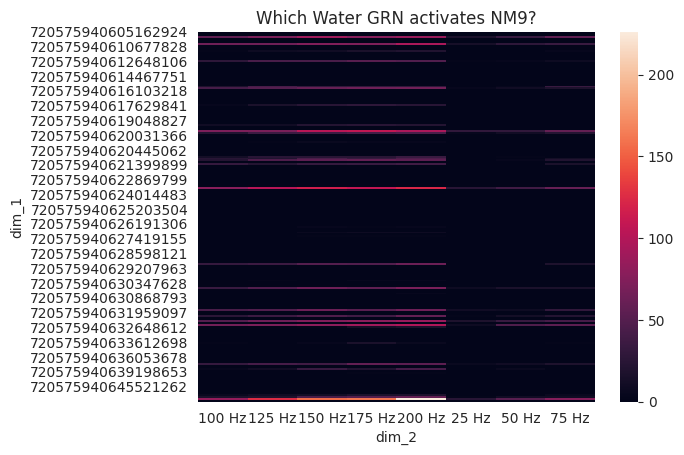

In [57]:
df = pd.read_csv(fig4_path_res / f'which_water_neuron_activate_NM9_firing_rate.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)

sns.heatmap(pivot_df)
plt.title('Which Water GRN activates NM9?')
plt.show()

### Figure 4c: Silencing Most Active Neurons while Activating Water GRN

In [58]:
# neuron indices
water_silencing_indices = np.asarray([flywire_id_to_index[id_] for id_ in id_top200])
water_silencing_indices = np.expand_dims(water_silencing_indices, axis=1)

In [59]:
def slice_water_neuron_and_activate_MN9(freqs):
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_freq(freq_, indices_):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_water, 'rate': freq_ * u.Hz}],
            neuron_to_inhibit=[{'indices': indices_}],
            duration=duration,
            pbar=10
        )
        return rate[index_id_mn9]

    def run_with_indices(indices_):
        return run_with_freq(freqs, indices_)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        # due to the limited memory of the device, we choose using "brainstate.transform.map" instead of "brainstate.transform.vmap"

        # return bst.transform.vmap(run_with_indices)(bst.random.split_key(len(water_silencing_indices)), water_silencing_indices)
        return brainstate.transform.map(run_with_indices, water_silencing_indices, batch_size=20)

    path = fig4_path_res / f'water_neuron_silencing_firing_rate.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                id_top200,
                [f'{freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
slice_water_neuron_and_activate_MN9(
    np.asarray([160, 170, 180, 190, 200, 210, 220])
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
df = pd.read_csv(fig4_path_res / f'water_neuron_silencing_firing_rate.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)

sns.heatmap(pivot_df)
plt.show()

### Figure 4e: Combination of sugar and water GRN activity

In [ ]:
sugar_freqs = np.asarray([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
water_freqs = np.asarray([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260])

In [ ]:
def sugar_water_activates_MN9():
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_sugar_freq(sugar_freq, water_freq):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_sugar, 'rate': sugar_freq * u.Hz},
                               {'ids': neu_water, 'rate': water_freq * u.Hz}],
            duration=duration,
            pbar=10,
        )
        return rate[index_mn9]

    @brainstate.transform.vmap
    def run_with_water_freq(water_freq):
        return run_with_sugar_freq(sugar_freqs, water_freq)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        return run_with_water_freq(water_freqs)

    path = fig4_path_res / f'sugar_water_activates_MN9.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'water {freq} Hz' for freq in water_freqs],
                [f'sugar {freq} Hz' for freq in sugar_freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
sugar_water_activates_MN9()

In [ ]:
df = pd.read_csv(fig4_path_res / f'sugar_water_activates_MN9.csv')
sns.heatmap(df)

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)

sns.heatmap(pivot_df)
plt.show()

## Figure 5

In [54]:
fig5_path_res = Path('./figure_5/data')
os.makedirs(fig5_path_res, exist_ok=True)

### Figure 5b: Whole Brain Activity when Activating JON

In [ ]:
# define inputs
# list of the  JONs
neu_JON_CE = [
    720575940619341105, 720575940630122015, 720575940611061526, 720575940615848788, 720575940628444667,
    720575940627941431, 720575940632449619, 720575940650244342,
    720575940631866508, 720575940638681845, 720575940628978450, 720575940609522461, 720575940621442224,
    720575940602506208, 720575940629022149, 720575940627109991,
    720575940630020111, 720575940615986459, 720575940618684481, 720575940620382889, 720575940630080071,
    720575940626565455, 720575940630319671, 720575940602720940,
    720575940630564179, 720575940637632419, 720575940615809349, 720575940626042149, 720575940637054835,
    720575940602132509, 720575940614188149, 720575940616951124,
    720575940628101126, 720575940629055721, 720575940616589878, 720575940622449388, 720575940614427195,
    720575940625797617, 720575940638664437, 720575940618467195,
    720575940621729757, 720575940613971485, 720575940627585688, 720575940629650997, 720575940630059847,
    720575940608742409, 720575940614351477, 720575940633153375,
    720575940622937528, 720575940604753437, 720575940611783464, 720575940618599872, 720575940609541917,
    720575940637410869, 720575940630070343, 720575940621397417,
    720575940614035485, 720575940610018266, 720575940626307902, 720575940634634606, 720575940614060829,
    720575940624799290, 720575940641921421, 720575940623298559,
    720575940625559358, 720575940629138959, 720575940621625597, 720575940625962568, 720575940632767383,
    720575940624915230]

neu_JON_F = [
    720575940606239243, 720575940626956777, 720575940604973746, 720575940622222856, 720575940642517284,
    720575940629719404, 720575940616613022, 720575940604299454,
    720575940615473186, 720575940622217992, 720575940606800341, 720575940629267498, 720575940637366335,
    720575940624224408, 720575940609543197, 720575940633364179,
    720575940629502009, 720575940606431189, 720575940625733960, 720575940638529525, 720575940617524053,
    720575940628935564, 720575940624308355, 720575940631170346,
    720575940627704375, 720575940625885512, 720575940614929245, 720575940647493241, 720575940618888368,
    720575940625087546, 720575940606657493, 720575940617273560,
    720575940640591861, 720575940639410035, 720575940621532413, 720575940627523584, 720575940621521917,
    720575940621097398, 720575940625915338, 720575940606222428,
    720575940627868471, 720575940622179497, 720575940608297774, 720575940614026269, 720575940613012959,
    720575940628100614, 720575940606611401, 720575940628649465,
    720575940610008217, 720575940623791152, 720575940625571240, 720575940634923621, 720575940609530653,
    720575940635968745, 720575940625703434, 720575940613105311,
    720575940629386819, 720575940623077389, 720575940625763015, 720575940628359017
]

neu_JON_D_m = [
    720575940630834171, 720575940622892988, 720575940621289537, 720575940641395163, 720575940616064546,
    720575940628978409, 720575940652566177, 720575940627493096,
    720575940619085397, 720575940635545310, 720575940645728803, 720575940629141775, 720575940626557995,
    720575940631098338, 720575940639904475, 720575940635067034]

neu_JON_all = neu_JON_CE + neu_JON_F + neu_JON_D_m

# frequencies
freqs = np.asarray([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220])

In [ ]:
def JON_GRN_whole_brain_activation():
    @brainstate.transform.vmap
    def run_with_freq(freq_):
        return run_one_exp(
            neurons_to_excite=[
                {
                    'ids': neu_JON_all,
                    'rate': freq_ * u.Hz
                }
            ],
            duration=duration,
            pbar=10,
        )

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def run_simulations():
        return run_with_freq(freqs)

    path = fig5_path_res / 'JON_GRN_whole_brain_firing_rate.csv'
    if not os.path.exists(path):
        rates = run_simulations()

        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'{freq} Hz' for freq in freqs],
                all_neuron_ids
            ],
            column_axis=0
        )
        df.to_csv(path)

        df_rate = df.loc['220 Hz'].mean(axis=1)
        df_rate_std = df.loc['220 Hz'].std(axis=1)

        # save 200 neurons for next simulation
        id_top300 = df_rate.sort_values(ascending=False).index[:300]

        print(df_rate.sort_values(ascending=False))

        with open(fig5_path_res / 'id_top300_water.pickle', 'wb') as f:
            pickle.dump(id_top300, f)

In [ ]:
JON_GRN_whole_brain_activation()

### Figure 5c: Which JON activates DN?

In [ ]:
# flywire ID for MN9
id_DN1_1 = 720575940616185531
id_DN2_l = 720575940629806974

index_DN = [flywire_id_to_index[id_DN1_1], flywire_id_to_index[id_DN2_l]]

# identify the top 200 neurons that respond due to 220 Hz JON firing (Figure 5A)
with open(fig5_path_res / 'id_top300_water.pickle', 'rb') as f:
    id_top300_JON = pickle.load(f)

In [ ]:
# frequencies
freqs = np.asarray([25, 50, 75, 100, 125, 150, 175, 200])

# neuron indices
JON_top300_indices = np.asarray([flywire_id_to_index[id_] for id_ in id_top300_JON])
JON_top300_indices = np.expand_dims(JON_top300_indices, axis=1)

In [ ]:
def which_JON_neuron_activate_DN():
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_freq(freq_, indices_):
        assert indices_.ndim == 1 and indices_.size == 1
        rate = run_one_exp(
            neurons_to_excite=[{'indices': indices_, 'rate': freq_ * u.Hz}],
            duration=duration,
            pbar=10
        )
        return rate[index_DN]

    def run_with_indices(indices_):
        return run_with_freq(freqs, indices_)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        # due to the limited memory of the device, we choose using "brainstate.transform.map" instead of "brainstate.transform.vmap"

        # return bst.transform.vmap(run_with_indices)(bst.random.split_key(len(JON_top300_indices)), JON_top300_indices)
        return brainstate.transform.map(run_with_indices,
                                        JON_top300_indices,
                                        batch_size=10)

    path = fig5_path_res / f'which_JON_neuron_activate_DN.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                id_top300_JON,
                [f'{freq} Hz' for freq in freqs],
                [id_DN1_1, id_DN2_l]
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
which_JON_neuron_activate_DN()

In [ ]:
df = pd.read_csv(fig5_path_res / f'which_JON_neuron_activate_DN.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)

sns.heatmap(pivot_df)
plt.title('Which JON GRN activates NM9?')
plt.show()

### Figure 5d: Silencing Most Active Neurons while Activating JON GRN

In [ ]:
# frequencies
freqs = np.asarray([140, 150, 160, 170, 180])

# neuron indices
JON_silencing_indices = np.asarray([flywire_id_to_index[id_] for id_ in id_top300_JON])
JON_silencing_indices = np.expand_dims(JON_silencing_indices, axis=1)

In [ ]:
def slice_water_neuron_and_activate_MN9():
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_freq(freq_, indices_):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_water, 'rate': freq_ * u.Hz}],
            neuron_to_inhibit=[{'indices': indices_}],
            duration=duration,
            pbar=10
        )
        return rate[index_DN]

    def run_with_indices(indices_):
        return run_with_freq(freqs, indices_)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        # due to the limited memory of the device, we choose using "brainstate.transform.map" instead of "brainstate.transform.vmap"

        # return bst.transform.vmap(run_with_indices)(bst.random.split_key(len(JON_silencing_indices)), JON_silencing_indices)
        return brainstate.transform.map(run_with_indices,
                                        JON_silencing_indices,
                                        batch_size=20)

    path = fig4_path_res / f'JON_neuron_silencing_firing_rate.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                id_top200,
                [f'{freq} Hz' for freq in freqs],
                [id_DN1_1, id_DN2_l]
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
slice_water_neuron_and_activate_MN9()

In [ ]:
df = pd.read_csv(fig4_path_res / f'JON_neuron_silencing_firing_rate.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)

sns.heatmap(pivot_df)
plt.show()

## Figure 5g + S5: Which JON Type activates aBN?

In [ ]:
id_aBN1 = 720575940630907434

index_aBN1 = flywire_id_to_index[id_aBN1]

# frequencies
freqs = np.asarray([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220])

### JON-CE

In [ ]:
def which_JONCE_neuron_activate_aBN():
    @brainstate.transform.vmap
    def run_with_freq(freq_):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_JON_CE, 'rate': freq_ * u.Hz}],
            duration=duration,
            pbar=10
        )
        return rate[index_aBN1]

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        return run_with_freq(freqs)

    path = fig5_path_res / f'JONCE_neuron_activate_aBN.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'{freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
which_JONCE_neuron_activate_aBN()

In [ ]:
df = pd.read_csv(fig5_path_res / f'JONCE_neuron_activate_aBN.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', values='mean')
pivot_df = pivot_df.fillna(0)

### JON-F

In [ ]:
def which_JONF_neuron_activate_aBN():
    @brainstate.transform.vmap
    def run_with_freq(freq_):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_JON_F, 'rate': freq_ * u.Hz}],
            duration=duration,
            pbar=10
        )
        return rate[index_aBN1]

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        return run_with_freq(freqs)

    path = fig5_path_res / f'JONF_neuron_activate_aBN.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'{freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
df = pd.read_csv(fig5_path_res / f'JONF_neuron_activate_aBN.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', values='mean')
pivot_df = pivot_df.fillna(0)

### JON-F + silencing

In [ ]:
three_inhibitory = [720575940636066222, 720575940609957315, 720575940624986407]

In [ ]:
def silence_which_JONF_neuron_activate_aBN():
    @brainstate.transform.vmap
    def run_with_freq(freq_):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_JON_F, 'rate': freq_ * u.Hz}],
            neuron_to_inhibit=[{'ids': three_inhibitory}],
            duration=duration,
            pbar=10
        )
        return rate[index_aBN1]

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        return run_with_freq(freqs)

    path = fig5_path_res / f'silence_JONF_neuron_activate_aBN.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'{freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
silence_which_JONF_neuron_activate_aBN()